# H20 TIMES SERIES

Using machine learning for solving time series problems

# Forecast for time series

## Initialization

In [3]:
import pandas as pd
import numpy as np
import urllib2
import datetime as dt
import matplotlib.pyplot as plt
from pandas import Series, DataFrame, Panel
 
%pylab inline

Populating the interactive namespace from numpy and matplotlib



## Preliminary
Sources :
* Base function
* White noise

### Base functions: 
* (unit) pulse 
* (unit) step
* ramp

In [217]:
def delta(t):
    if t == 0:
        return 1
    return 0

def step(t):
    if t >= 0:
        return 1
    return 0

def ramp(t):
    return max(0,t)

Defining discrete time domain

In [226]:
t = range(-20,40)

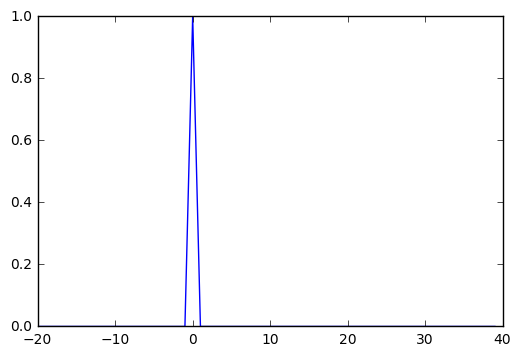

In [227]:
plt.plot(t,map(delta,t))

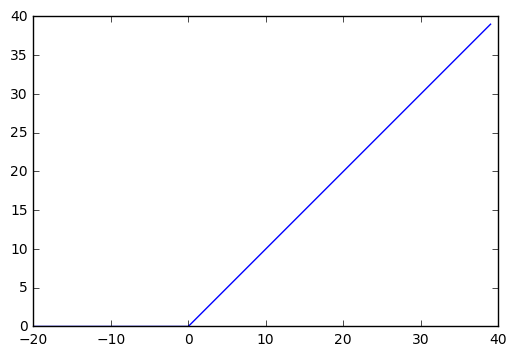

In [228]:
plt.plot(t,map(ramp,t))

### Random process: white noise
Example a white noise process with mean=0, std=1, 1000 samples

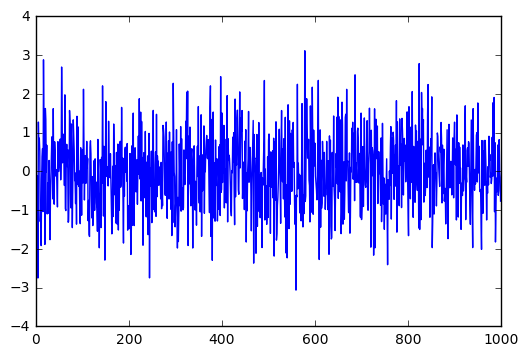

In [219]:
e = standard_normal([10000])
plt.plot(e[:1000])

(array([    5.,    40.,   233.,  1106.,  2454.,  2997.,  2160.,   775.,
          213.,    17.]),
 array([-4.24132253, -3.45488926, -2.66845599, -1.88202272, -1.09558945,
        -0.30915618,  0.47727709,  1.26371036,  2.05014363,  2.8365769 ,
         3.62301017]),
 <a list of 10 Patch objects>)

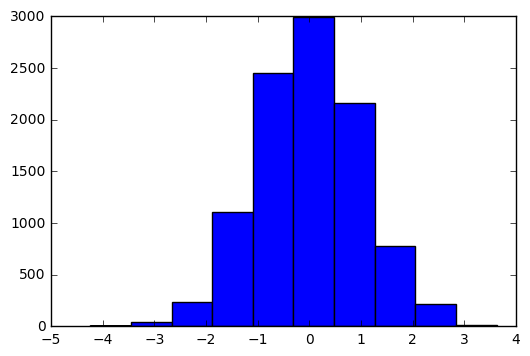

In [8]:
plt.hist(e, bins=10)

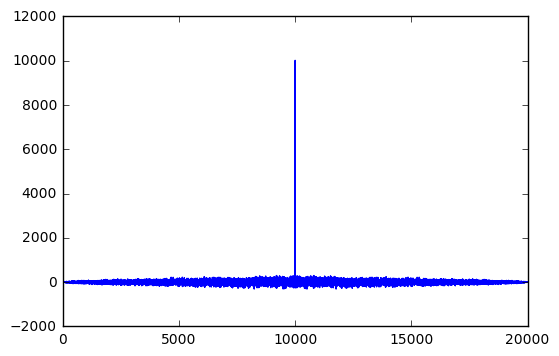

In [9]:
plt.plot(np.correlate(e,e,mode='full')[:])

## Linear time invariant models (LTI aka ARMA / ARIMA)

Base model for time series

𝑦_𝑖_=_𝑘=0𝑛__𝑏_𝑘_𝑢_𝑖−𝑘__−_𝑘=1𝑛__𝑎_𝑘_𝑦_𝑖−𝑘__


In [229]:
def LTI(a,b,u,u0=None,y0=None):
    n = len(a)
    m = len(b)
    s = len(u)
    a = a[::-1]
    b = b[::-1]
    if not u0:
        u0 = np.zeros(m-1)
    else:
        u0 = np.array(u0)
    if not y0:
        y0 = np.zeros(n)
    else:
        y0 = np.array(y0)
    y = np.concatenate((y0,np.empty(s)))
    u = np.concatenate((u0,u))
    for i in range(s):
        y[i+n] = - np.dot(a,y[i:i+n]) + np.dot(b,u[i:i+m])
    return y[n:s+n]

### Pulse response

Pulse response characterizes a linear system: any output is determined by the convolution between the input and pulse response:

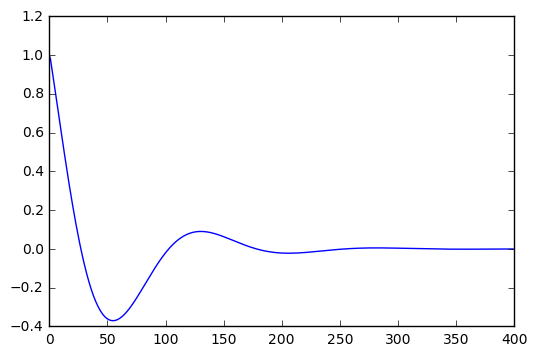

In [286]:
a = np.array([-1.98,1,-0.018])
b = np.array([1, -1])

u = map(delta,range(400))
y = LTI(a,b,u)
plt.plot(y)

### Convolution

Response can be found as convolution of input with pulse response


With previous model:

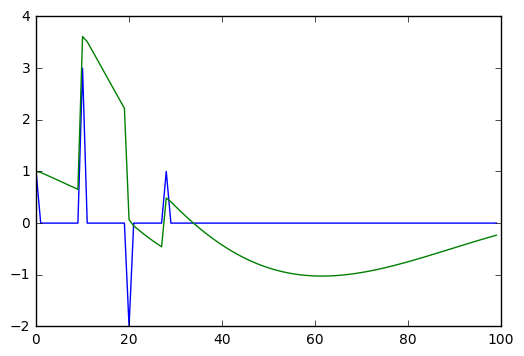

In [287]:
u1 = np.pad(np.array([1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,-2,0,0,0,0,0,0,0,1]),(0,950),'constant')
y = LTI(a,b,u1)
plt.plot(u1[:100])
plt.plot(y[:100])

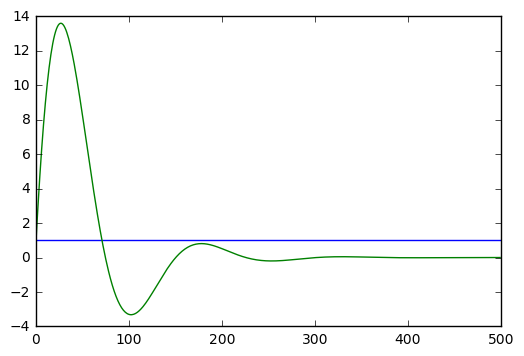

In [288]:
u1 = map(step,range(500))
y = LTI(a,b,u1)
plt.plot(u1)
plt.plot(y)

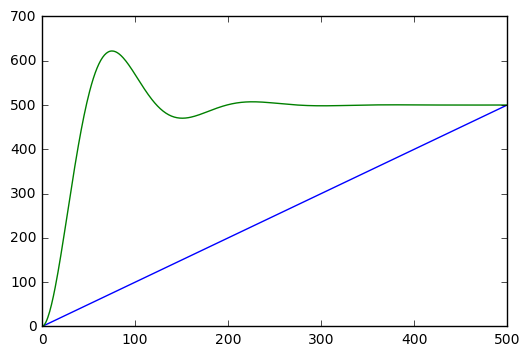

In [234]:
u2 = map(ramp,range(500))
y = LTI(a,b,u2)
plt.plot(u2)
plt.plot(y)

### Auto Correlation

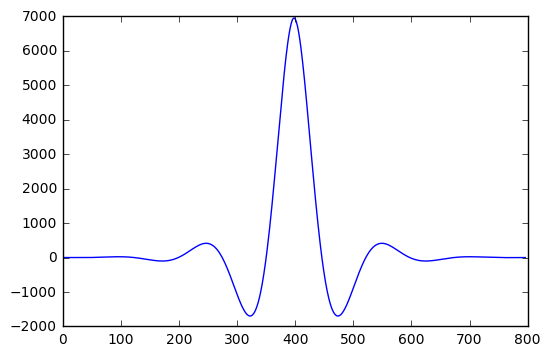

In [17]:
dy = np.diff(y)
plt.plot(np.correlate(dy,dy,mode='full')[:])

### Response to white noise

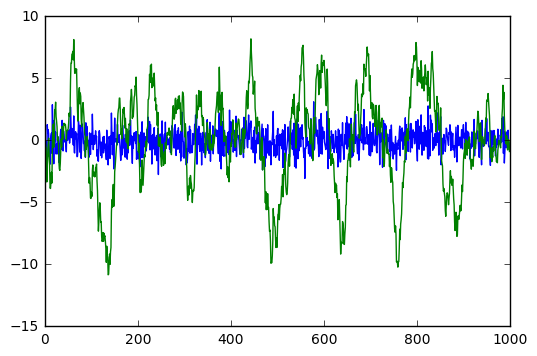

In [238]:
y = LTI(a,b,e)
plt.plot(e[:1000])
plt.plot(y[:1000])

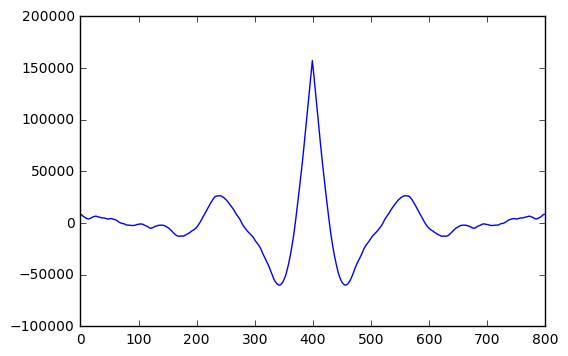

In [236]:
plt.plot(np.correlate(y,y,mode='full')[9600:10400])

## Linear state-space models

More general formulation (matricial) with better insight of internal dynamic condition: the state space.
Formulation decoupled in to parts: 
1. Output equation
2. State update equation

In [21]:
def statemodel(A,B,C,D,uu,x0=None):
    if not ndim(x0) :
        x = np.zeros(len(A))
    else:
        x = x0[-1]
    try:                            # State update
        xx = state(A,B,uu,x)       
    except:
        print "Error in state update"
    try:                            # Output calculation
        return np.dot(xx[:-1],np.transpose(C)) + np.array(uu)*D
    except:
        print "Error in output determination"
 
# Get calculation of linear state model
def state(A,B,uu,x):
    xx = np.empty((len(uu)+1,len(A)))
    xx[0]=x
    for i in range(len(uu)):
        x = np.dot(A,x)+ np.dot(B,uu[i])
        xx[i+1] = x
    return xx

### Converting transfer function formulation to state formulation
Canonical realization (for proper transfer function)

In [22]:
def LTItoState(a,b):
    n=len(a)
    A=np.concatenate(([-a],np.transpose(np.concatenate((np.eye(n-1),[np.zeros(n-1)])))))
    B=np.array(map(delta,range(n)))
    C=b[1:]
    D=b[0]
    return (A,B,C,D)

In [241]:
a = np.array([-1.98,0.99])
b = np.array([ 0, 5, -5])

In [242]:
(A,B,C,D)=LTItoState(a,b)
(A,B,C,D)

(array([[ 1.98, -0.99],
        [ 1.  ,  0.  ]]), array([1, 0]), array([ 5, -5]), 0)

### Response to unit pulse

u = map(delta,range(1000))
y = LTI(a,b,u)
plt.plot(y[:500])

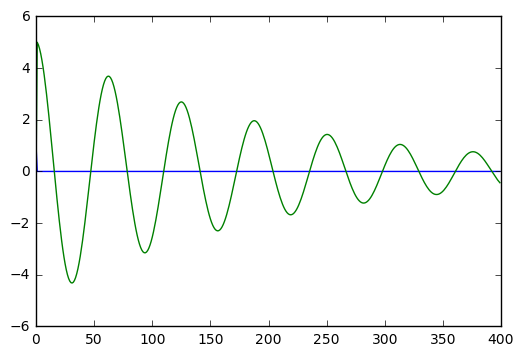

In [243]:
y = statemodel(A,B,C,D,u)
plt.plot(u[:500])
plt.plot(y[:500])

In [ ]:
Changing parameters

In [251]:
b = np.array([0,0.5,0])
(A,B,C,D)=LTItoState(a,b)

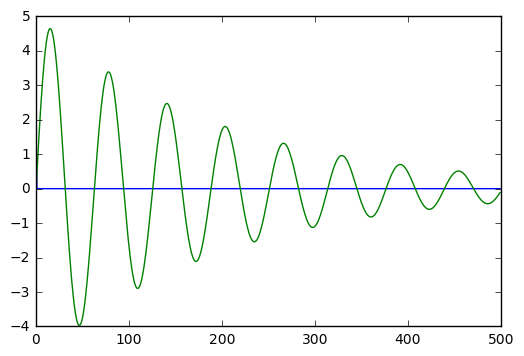

In [252]:
u = map(delta,range(500))
y = statemodel(A,B,C,D,u)
plt.plot(u)
plt.plot(y)

### Response to white noise input (Gaussian, sigma=1)

In [248]:
e = standard_normal([100000])

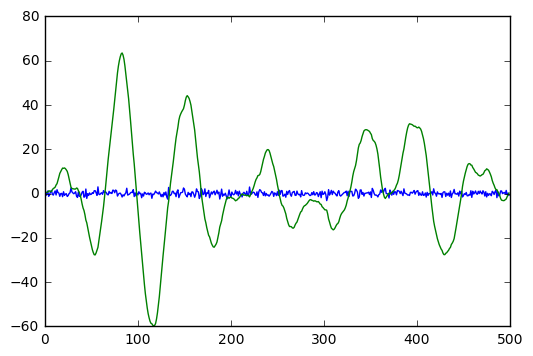

In [253]:
y = statemodel(A,B,C,D,e)
plt.plot(np.transpose([e[:500],y[:500]]))

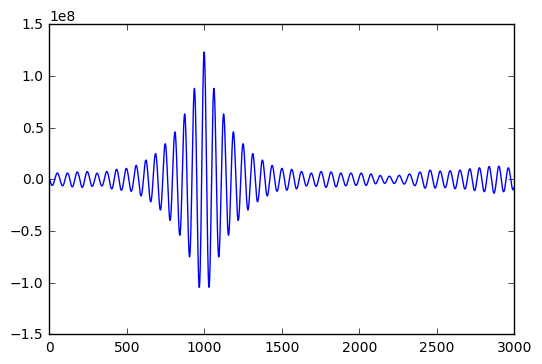

In [254]:
plt.plot(np.correlate(y,y,mode='full')[99000:102000])

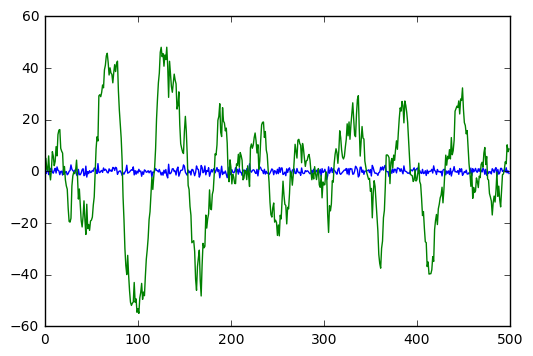

In [255]:
b = np.array([ 0, 5, -5])
(A,B,C,D)=LTItoState(a,b)
y = statemodel(A,B,C,D,e)
plt.plot(np.transpose([e[:500],y[:500]]))

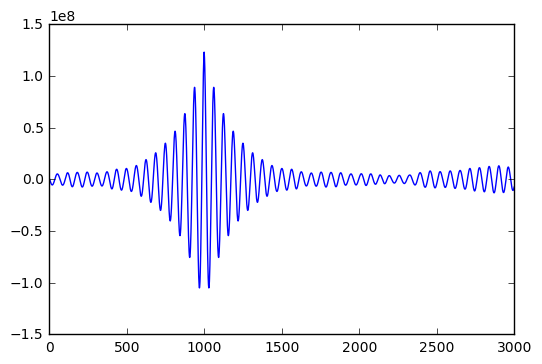

In [256]:
plt.plot(np.correlate(y,y,mode='full')[99000:102000])

### Phase diagram

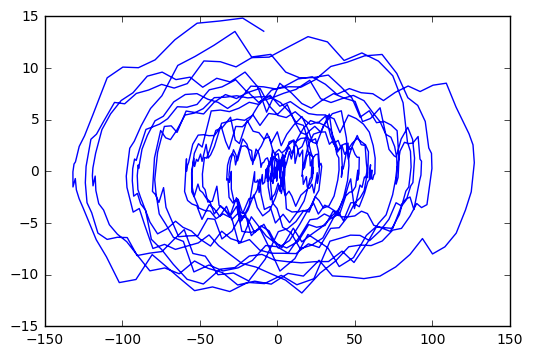

In [257]:
xx = state(A,B,e[:1000],[0,0])
x0 = np.transpose(xx)[0]
x1= np.transpose(xx)[0]-np.transpose(xx)[1]
plt.plot(x0,x1)

### Phase diagram for pulse response

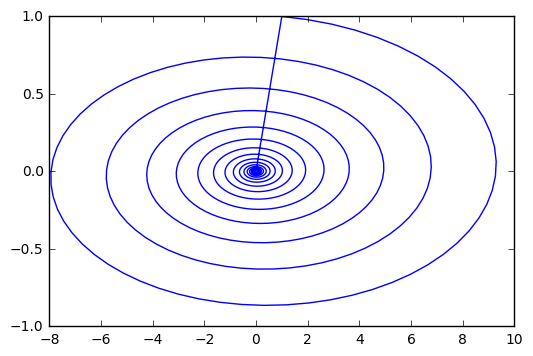

In [258]:
xx = state(A,B,map(delta,range(1000)),[0,0])
x0 = np.transpose(xx)[0]
x1= np.transpose(xx)[0]-np.transpose(xx)[1]
plt.plot(x0,x1)

### Eigenvalues and eigenvectors

Dynamic behavior is defined by state transition matrix A

In [43]:
np.linalg.eig(A)

(array([ 0.99+0.09949874j,  0.99-0.09949874j]),
 array([[ 0.70179239+0.07053279j,  0.70179239-0.07053279j],
        [ 0.70888121+0.j        ,  0.70888121-0.j        ]]))

#### Unstable case

The system is unstable when the the real part of some eigenvalue is greater than 1

Examples:

In [44]:
a = np.array([-2.01,1.012])
(A,B,C,D)=LTItoState(a,b)
np.linalg.eig(A)

(array([ 1.005+0.04444097j,  1.005-0.04444097j]),
 array([[ 0.70921231+0.j        ,  0.70921231-0.j        ],
        [ 0.70430670-0.03114435j,  0.70430670+0.03114435j]]))

Eigenvalues are  1.005 +- 0.04444j

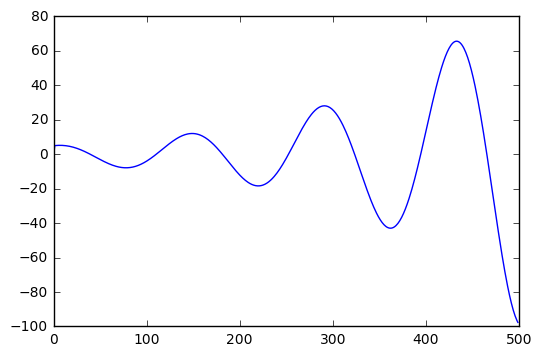

In [1071]:
y = statemodel(A,B,C,D,map(delta,range(1000)))
plt.plot(y[:500])

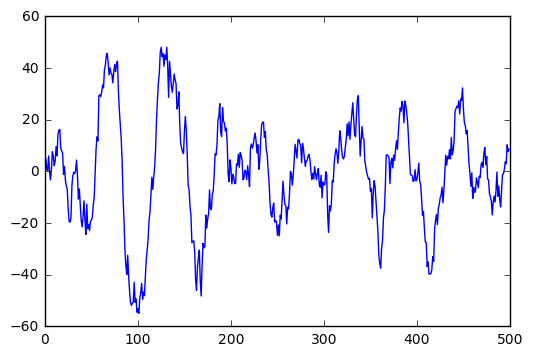

In [260]:
y = LTI(a,b,e)
plt.plot(y[:500])

## Identification: finding parameters given inputs and outputs

The problem is to find the right parameters knowing the inputs and outputs. This can be done by minimizing the square of the prediction error (difference between the right value and predicted)

### Least square estimate

In [54]:
def LSqEstimate(y,u,n=2,m=2):
    x = makeX(y,u,n,m)
    R = np.dot(np.transpose(x),x)
    w = np.dot(inv(R),np.dot(y,x))
    a = -w[:n]
    b = np.append([0],w[n:])
    return (a,b)


def makeX(y,u,n=2,m=2):
    x=[]
    for i in range(1,n+1):
        x.append(np.pad(y[:-i],(i,0),'constant'))
    for i in range(1,m+1):
        x.append(np.pad(u[:-i],(i,0),'constant'))
    return np.transpose(x)

def findX(y,u,n=2,m=2):
    if len(y)<=n:
        y = np.pad(y,(n,0),'constant')
        print "y :", y
    if len(u)<=m:
        u = np.pad(u,(m,0),'constant')
        print "u : ", u
    return np.append(u[-m-1:-1],y[-n-1:-1])[::-1]

Example

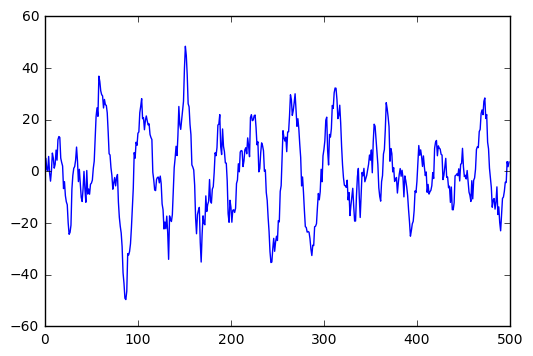

In [261]:
a = np.array([-1.96,0.98])
b = np.array([ 0, 5, -5])
y = LTI(a,b,e)
plt.plot(y[:500])

In [262]:
LSqEstimate(y,e)

(array([-1.96,  0.98]), array([ 0.,  5., -5.]))

### Recursive least squares

The idea is to obtain best parameters with information available until certain time, starting previous estimate.

In [263]:
def RLSstep(yt,x,w,P,lm=1):
    Px = np.dot(P,x)
    k  = Px/(1 + np.dot(x,Px)/lm)/lm
    et = yt - np.dot(x,w)
    w  = w + k*et
    P  = (P - np.outer(k,np.dot(x,P)))/lm
    return (w,P)

def RLS(y,u,a,b,P=100,lm=0):
    k = len(y)
    x = makeX(y,u,len(a),len(b)-1)
    print "dims of x: ", shape(x)
    w = np.append(a,b[1:])
    ww = np.empty([len(y),len(w)])
    if type(P) == float or type(P) == int:
        P = P * np.eye(len(w))
    for i in range(len(y)):
        (w,P) = RLSstep(y[i],x[i],w,P,lm)
        ww[i] = w
    a = - w[:len(a)]
    b = np.append([0],w[len(a):])
    print " a :", a , " b :", b
    return (a, b, P, ww)
        
        

dims of x:  (100000, 4)
 a : [-1.94958311  0.96948596]  b : [ 0.          0.51342551 -0.00923545]


### Standard Recursive Least Square method

No forgetting factor is applied: all data is used (with same weight)

In [264]:
(a,b,P,w) = RLS(y,e,np.array([0,0]),np.array([0,0,0]),1,1)

dims of x:  (100000, 4)
 a : [-1.95997704  0.97997772]  b : [ 0.          4.99994974 -4.99983538]


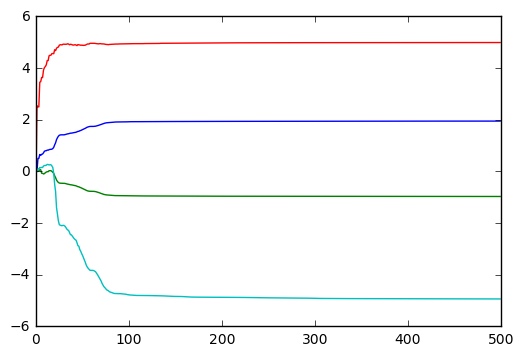

In [265]:
plt.plot(w[:500])

## Linear Time variant systems
Recursive on line identification becomes more interesting and useful with time variant systems

Linear time variant has linear equations that relate inputs and output, that are valid at given time: linear parameter may change value at each time slot

In [78]:
def LTV(fa,fb,u,u0=None,y0=None):
    n = len(fa(0))
    m = len(fb(0))
    s = len(u)
    if not u0:
        u0 = np.zeros(m-1)
    else:
        u0 = np.array(u0)
    if not y0:
        y0 = np.zeros(n)
    else:
        y0 = np.array(y0)
    y = np.concatenate((y0,np.empty(s)))
    u = np.concatenate((u0,u))
    for i in range(s):
        a = fa(i)[::-1]
        b = fb(i)[::-1]
        y[i+n] = - np.dot(a,y[i:i+n]) + np.dot(b,u[i:i+m])
    return y[n:s+n]

Defining functions for time variant parameters

In [274]:
def fa(i):
    if i < 400:
        return [-1.98,0.99]
    elif i < 600:
        return [-2, 1]
    return [-1.96,0.98]

def fb(i):
    if i < 200:
        return [0, 5, -5]
    elif i < 500:
        return [0, 2, 0]
    return [0, 0.5, 0]

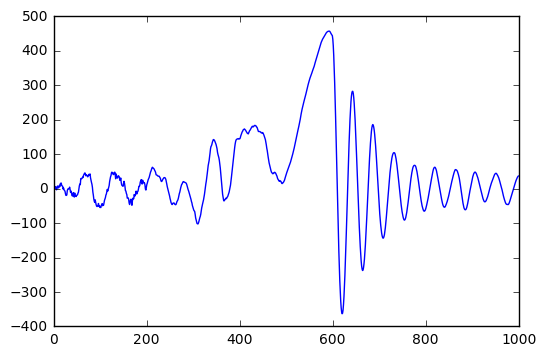

In [275]:
y = LTV(fa,fb,e[:2000])
plt.plot(y[:1000])

### Recursive least squares (RLS) with forgetting factor
Able to track rapidly changing parameters of linear time variant system

In [282]:
(a,b,P,w) = RLS(y,e[:2000],np.array([0,0]),np.array([0,0,0]),1,0.9)

dims of x:  (2000, 4)
 a : [-1.96  0.98]  b : [  0.00000000e+00   5.00000000e-01  -1.56406176e-17]


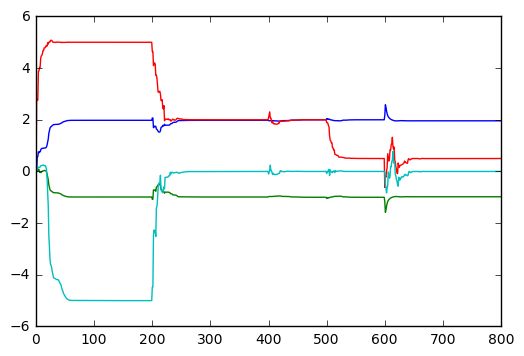

In [283]:
plt.plot(w[:800])

Comparing actual parameters with those found using RLS procedure

In [133]:
aa = np.array(map(fa,range(1000)))
bb = np.array(map(fb,range(1000)))
ww = np.concatenate((-aa,bb),axis=1)

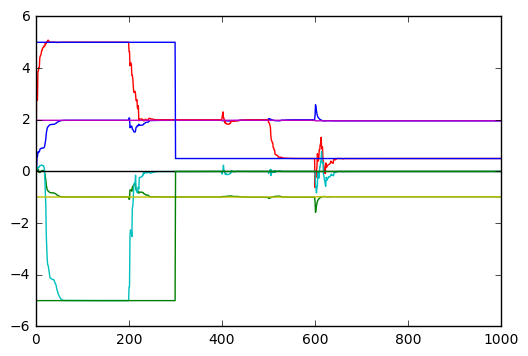

In [284]:
plt.plot(w[:1000])
plt.plot(ww)